In [1]:
# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

<h1>Downloading and processing data</h1>

For now, just working with one neutrino distribution model at a time.

The model has multiple components, but we only care about a few for now.

<h2>Spatial distribution</h2>

We are given $N$ neutrinos, each with their own position in $3D$ space. We thus have the following:
$$
\mathrm{Dist}(\vec{x}) = \delta^3(\vec{x} - \vec{x}_{\nu_1}) + \delta^3(\vec{x} - \vec{x}_{\nu_2}) + \dots + \delta^3(\vec{x} - \vec{x}_{\nu_N}).
$$

However, this isn't very helpful to us: in practice, we aren't going to be able to distinguish individual point neutrino sources. So we want to turn this discrete distribution into some continuous probability density distribution, $P_{\nu_e + \nu_{\mu}}(\vec{x})$.

We thus histogram over 3D spatial bins and count the number of neutrinos in each bin, then divide by the bin volume and the total number of neutrinos.


In [113]:
# Getting the model-dependent neutrino distribution

model_2 = readdlm("nu_models/second_GC_model.txt", comments=true)
numv = size(model_2)[1]


# Histogramming and interpolating the distribution

bsize = 0.3
xbins, ybins, zbins = -30:bsize:30, -30:bsize:30, -3:bsize:3
nubins= fit(Histogram, (vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26])), (xbins, ybins, zbins), closed=:left)

binvals = nubins.weights ./ (numv*bsize^3)
xedges = collect(xbins)
yedges = collect(ybins)
zedges = collect(zbins)
pop!(xedges)
pop!(yedges)
pop!(zedges)

# Interpolating the distribution to get a continuous function, and assuming zero neutrinos outside the sampled window
pds = interpolate((xedges, yedges, zedges), binvals, Gridded(Linear()))
probdens = extrapolate(pds, 0.0)

# To not have the massive array show up, throwaway variable
zcx=0

0

In [9]:
# Downloading and interpolating the effective area data

eff_a = readdlm("EffA_GC_approx.csv", ',')
itp = interpolate((eff_a[:, 1],), eff_a[:, 2], Gridded(Linear())) # in m^2
effarea = extrapolate(itp, fill(0))

# The min and max energy vals (in TeV) we consider based on the limits of the effective area function
emin = 0.7916819159263001
emax = 791.6819159263017

791.6819159263017

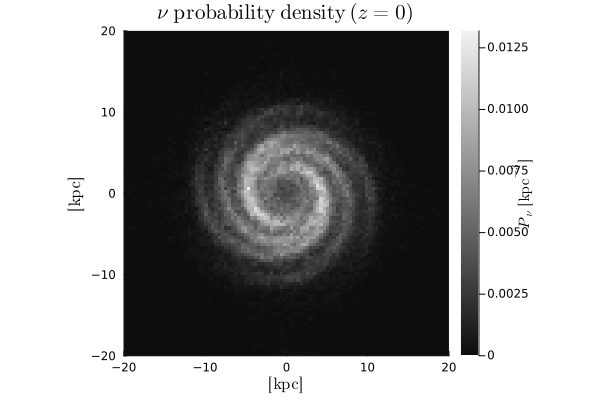

In [111]:
# Plotting neutrino distributions

xs = range(-20, 20, length=100)
ys = range(-20, 20, length=100)

grid = Iterators.product(xs, ys)
zvals = [probdens(x, y, 0) for (x, y) in grid]
zmat = reshape(zvals, length(xs), length(ys))

# z = probdens(xs, ys, 0)
heatmap(
    xs, 
    ys, 
    zmat, 
    xlims=(-20,20), 
    ylims=(-20,20), 
    aspect_ratio=1,
    c=:grays,
    xlabel=L"[\mathrm{kpc}]",
    ylabel=L"[\mathrm{kpc}]",
    title=L"\nu~\mathrm{probability~density}~(z=0)",
    colorbar_title=L"P_{\nu}~[\mathrm{kpc}^{-3}]"
)

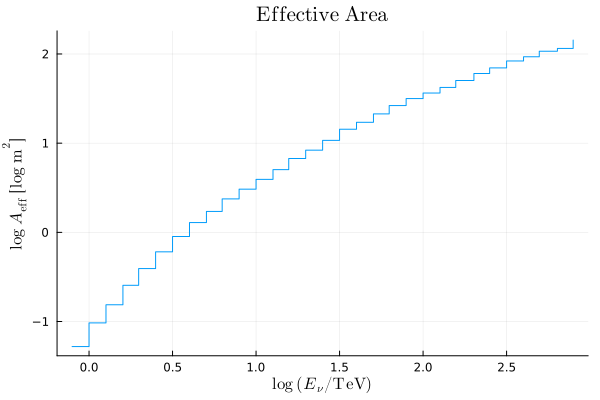

In [153]:
# Plotting effective area

plot(
    log10.(eff_a[:, 1]),
    log10.(eff_a[:, 2]),
    seriestype=:step,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\log~A_{\mathrm{eff}}~[\log~\mathrm{m}^2]",
    title=L"\mathrm{Effective~Area}",
    label=false
)

<h1>Model building</h1>

Let's start building our event distribution model.

<h2>Energy distribution</h2>

Currently, the models we have aren't fine-tuned enough for us to care about their own energy distributions. We thus assume independence of energy and spatial distribution and inject our own energy distribution in the form of a power law. This is consistent with the $\pi^0$ model used in the Galactic plane paper.
$$
\Phi_{\nu_{e} + \nu_{\mu}} \sim E^{-\gamma}
$$
for some spectral index $\gamma$.

So far all of this is unitless. We add units to our flux with the normalization factor $\Phi_0$. We're given the flux normalization factor in units of $E^2 \frac{dN}{dE}$, or differential per-flavor counts of neutrinos ($N_{\nu}$) multiplied by energy squared, at $E = 100~\mathrm{TeV}$. This is given in units of $10^{-12}~\mathrm{TeV}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}$, or specifically $21.8 \times 10^{-12}~\mathrm{TeV}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}$.

What does this mean? Well, it means that at $100$ TeV, we expect the neutrino energy density to be $21.8 \times 10^{-16}~\mathrm{TeV}^{-1}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}$. 

<h2>Event distributions (null case)</h2>

This means that by accounting for the spatial weights from the above model and the effective area of our detector, we can derive an expression for the total number of events expected in energy bin $[E_0, E_1]$ from spatial bin $S$:
$$
N_{\nu} \in [E_0, E_1] \times S = \int_S d^3\vec{x}~P_{\nu}(\vec{x})~\int_{E_0}^{E_1} dE_{\nu}~\Phi_0 \left(\frac{E_{\nu}}{E_0}\right)^{-\gamma} A_{\mathrm{eff}}(E_{\nu}).
$$

<h2>Pseudo-Dirac oscillations</h2>

We now need to take into account the possibility for pseudo-Dirac oscillations. The probability that a neutrino in the flavor state $\alpha$ oscillates into flavor state $\beta$ can be described by the following expression:
$$
O_{\alpha \to \beta} = \sum_j |U_{\alpha j}|^2 |U_{\beta j}|^2 \cos^2\left(\frac{\delta m_j^2 L_{\mathrm{eff}}}{4E_{\nu}}\right),
$$
where $U_{ij}$ are values of the PMNS matrix, $\delta m_i^2$ is the pseudo-Dirac mass-splitting value between active and sterile versions of mass state $i$, and $L_{\mathrm{eff}}$ is the distance the neutrino has propagated in space.

We now can write an expression for the expected number of neutrinos coming from angular bin $A = (l, b, \Theta)$, where $\Theta$ is the width of the bin in radians:
$$
N_{\nu} \in [E_0, E_1] \times A = \int_0^{\infty}dr~\int_{A}d\vec{\theta}~P_{\nu}(r, \vec{\theta})\int_{E_0}^{E_1} dE_{\nu}~\Phi_0 \left(\frac{E_{\nu}}{E_0}\right)^{-\gamma} A_{\mathrm{eff}}(E_{\nu})O_{(e,~\mu) \to e}(E_{\nu}, r).
$$

In [7]:
# Functions that return areas of square latitude-longitude bins on a sphere's surface

function spherebinareas(r)
    ϕs = range(0, 2π, length=50)
    θs = range(-π/2, π/2, length=25)

    Δϕ = ϕs[2] - ϕs[1]
    sinθs = sin.(θs)

    bin = zeros(length(ϕs)-1, length(θs)-1)

    for i in 1:length(ϕs)-1
        for j in 1:length(θs)-1
            bin[i, j] = r^2 * Δϕ * (sin(θs[j+1]) - sin(θs[j]))
        end
    end

    return bin
end

# Function that returns the area on a sphere of radius r for an angular bin centered at angle (l, b) with size θ
function sbinarea(r, l, b, θ)

    Δl = θ

    Δsinb = abs(sin(b+(θ/2)) - sin(b-(θ/2)))

    area = r^2 * Δl * Δsinb

end

function sbinareas1(r, bsize)


    bedges = (-π/2):bsize:(π/2)
    ledges = 0:bsize:(2π)

    bbins = collect((-π/2 + bsize/2):bsize:(π/2 - bsize/2))
    lbins = collect((0 + bsize/2):bsize:(2π - bsize/2))

    bin = zeros(length(lbins), length(bbins))

    for (i, l) in enumerate(lbins)
        for (j, b) in enumerate(bbins)
            bin[i, j] = sbinarea(r, l, b, bsize)
        end
    end

    return bin
end


# Flux calculation functions 

function oscprob(et, dm2, leff)

    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    osc = (cos((dm2 * leff)/(4*et*1e12)))^2
    # osc2 = (cos((dm2 * leff)/(4*et*1e12)))^2
    # osc3 = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_surv = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_mue = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

function flux(et, x, y, z, γ)
    ϕ₀ = 21.8e-16 * 3.156e8 # TeV^-1 cm^-2
    e0 = 100.0 # TeV
    as = ϕ₀ * (et/e0)^(-γ)
    flx = probdens(x, y, z) * as
end

function flx(et, x, y, z, ϕ₀, γ, e0)
    flx = probdens(x, y, z) * ϕ₀ * (et/e0)^(-γ) * 1e-16 * 3.156e8
end

function cartesian(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    y = r*sin(l)*cos(b)
    z = r*sin(b)
    return [x, y, z]
end

function cartx(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    return x
end

function carty(r, l, b)
    y = r*sin(l)*cos(b)
    return y
end

function cartz(r, l, b)
    z = r*sin(b)
    return z
end

cartz (generic function with 1 method)

<h2>Plotting flux and oscillation probability</h2>

To get a feel for where we should expect dips and what our flux looks like, let's plot these:

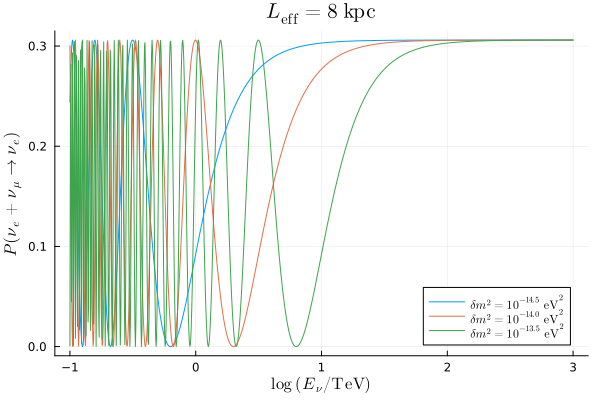

In [135]:
# Plotting oscillation probability

logesample = range(-1, 3, 1000)
esample = 10 .^ logesample

plot(
    logesample,
    [oscprob.(esample, 10^(-14.5), 8) oscprob.(esample, 10^(-14), 8) oscprob.(esample, 10^(-13.5), 8)],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{e} + \nu_{\mu} \to \nu_{e})",
    label=[L"\delta m^2 = 10^{-14.5}~\mathrm{eV}^2" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2" L"\delta m^2 = 10^{-13.5}~\mathrm{eV}^2"],
    title=L"L_{\mathrm{eff}} = 8~\mathrm{kpc}"

)

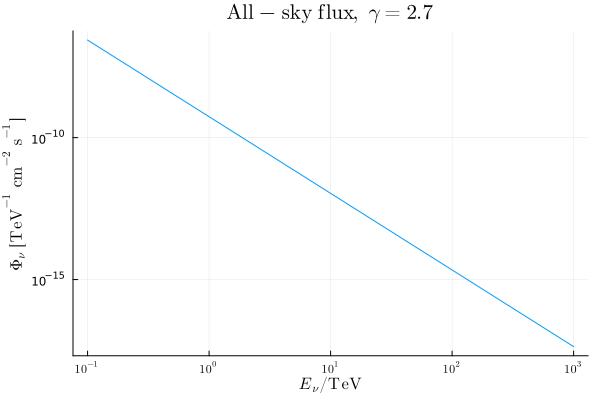

In [147]:
# Plotting flux 

function allskyfluxnoeffarea(et, γ)
    ϕ₀ = 21.8e-16
    e0 = 100
    flx = ϕ₀ * (et/e0)^(-γ) # * effarea(et) * 10000
end

logesample = range(-1, 3, 1000)
esample = 10 .^ logesample

plot(
    esample,
    allskyfluxnoeffarea.(esample, 2.7),
    xscale=:log10,
    xticks=([1e-1, 1e0, 1e1, 1e2, 1e3], [L"10^{-1}" L"10^{0}" L"10^1" L"10^2" L"10^3"]),
    yscale=:log10,
    xlabel=L"E_{\nu} / \mathrm{TeV}",
    ylabel=L"\Phi_{\nu}~[\mathrm{TeV}^{-1}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}]",
    label=false,
    title=L"\mathrm{All-sky~flux},~\gamma = 2.7"
)


<h2>Checks</h2>

What do we expect with the functions we have so far?

Firstly, we expect that the probability density function integrates to 1 when consider the whole sky. Let's check this:

In [21]:
# Function that calculates weight integral along logebins
function weightint(l, b, θ)
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    vols = blength .* sbinarea.(rbins, l, b, θ)

    pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

    return sum(vols .* pds)
end

# How large our latitude-longitude bins are
bsize = π/100

b_range = (-π/2+bsize):bsize:(π/2-bsize)
l_range = (0+bsize/2):bsize:(2π-bsize/2)

skybins = []
for l in l_range
    for b in b_range
        push!(skybins, weightint(l, (-b), bsize))
    end
end

# The sum of this skybins vector should approximate the integral of the probability density function
# over the whole sky, which should be 1:
pd_integral = sum(skybins)

1.0793614278839891

This checks out!

We also expect that the integral over all energy of the flux multiplied by the (energy dependent) effective area should be around 600-700, because this is the number of events the $\pi^0$ map predicts (for a spectral radius $\gamma = 2.7$). Let's check this:

In [129]:
function allskyflux(et, γ)
    ϕ₀ = 21.8e-16 * 3.156e8
    e0 = 100
    flx = ϕ₀ * (et/e0)^(-γ) * effarea(et) * 10000
end

# Log integral with jacobian
function logintegral(γ)
    nsteps = 200
    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = allskyflux.((10 .^ us), γ) .* du .* (10 .^ us) .* log(10)
    int = sum(steps)
end

# True integral without jacobian
function trueintegral(γ)
    nsteps = 100000
    es = range(emin, emax, nsteps)
    de = es[2] - es[1]
    steps = allskyflux.(es, γ) .* de
    int = sum(steps)
end

logint = logintegral(2.7)
trueint = trueintegral(2.7)
println("log integral: $logint \ntrue integral: $trueint")

log integral: 668.0504164459727 
true integral: 666.34857700337


We also expect that, because the spatial distribution density function and the flux function are independent of each other, that the integral of their product (the weighted flux integral) over the whole sky should yield the same number of events as above. Let's check this:

In [33]:
# Multiplying the pdf by the flux
function weightedskyflux(et, γ, l, b, θ)
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    vols = blength .* sbinarea.(rbins, l, b, θ)

    pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

    losint = sum(vols .* pds .* allskyflux(et, γ))
end

function weightedintegral(γ)
    
    function esteps(et, γ)
        bsize = π/100

        b_range = (-π/2+bsize):bsize:(π/2-bsize)
        l_range = (0+bsize/2):bsize:(2π-bsize/2)

        skybins = []
        for l in l_range
            for b in b_range
                push!(skybins, weightedskyflux(et, γ, l, (-b), bsize))
            end
        end
        return sum(skybins)
    end

    nsteps = 200
    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = esteps.((10 .^ us), γ) .* du .* (10 .^ us) .* log(10)
    int = sum(steps)
end

allskyweightedint = weightedintegral(2.7)


721.0678513936189

While this is a little high, consider that with `bsize = pi/100`, the PDF integrates to something a bit above one: $1.07936\dots$. So when multiplying our unweighted log integral result for when `nsteps = 200`, which is $668.0504$, we get $721.0669$, which is remarkable close to our result. So the discrepancy is just a result of compounded error. This does, however, indicate that we want to take as small bins as possible when calculating our final integral to preserve accuracy.

<h2>Energy smearing</h2>

IceCube isn't a perfect detector, unfortunately: for each event, we don't know for certain what the event's real energy and direction were. We can make an educated guess (and these educated guesses are getting better and better with more tech and research advances) and return some reconstructed energy and angle, but these aren't going to be perfect.

Let's quantify this error: for cascade events, the probability that, given some true energy $E_t$, IceCube reconstructs the energy $E_r$, is given by the following PDF (we now work in $\log_{10}$ energy, so $u_i = \log_{10} E_i$):
$$
G(u_r | u_t,~\sigma) = \ln(10)~10^{u_r - u_t}~N(\mathrm{abs}\left(1 - 10^{u_r - u_t}\right)|0,~\sigma),
$$
with $N$ being the normal distribution with standard deviation $\sigma$.

We can convolve this with our energy dependent functions in log energy space to accurately smear the energy distribution.

<h2>The Likelihood Ratio Test</h2>

How do we test how well hypothetical data is able to distinguish between two hypotheses? We use a likelihood ratio test!

To calculate the likelihood that data $k$ match a hypothesis $\lambda$, we assume a Poisson distribution and use the poisson likelihood:
$$
\mathrm{Poisson}(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}.
$$
This likelihood is bin-dependent: to determine the likelihood over $n$ energy bins, we get
$$
\mathrm{Poisson}(k_1, k_2, \dots, k_n | \lambda) = \prod_{i=1}^{n} \mathrm{Poisson}(k_i|\lambda).
$$
To simplify calculations, we know that the maximum of a function is achieved at the maximum of the log of the function. We thus get
$$
\log \mathrm{Poisson}(k_1, k_2, \dots, k_n | \lambda) = \sum_{i=1}^{n} \log \mathrm{Poisson}(k_i|\lambda).
$$
To determine the relative "goodness" of a null and alternative hypothesis (in this case, null is the Standard Model and alt is any pseudo-Dirac scenario), we take the ratio (or, for log likelihood, the difference) of the likelihood of the data given the null vs. likelihood of the data given the alt. Multiplying by $-2$ for convention, we achieve our test statistic:
$$
TS = -2~\sum_{i=1}^{n} ( \log \mathrm{Poisson}(k_1, \dots, k_n | \mathrm{null}) - \log \mathrm{Poisson}(k_1, \dots, k_n | \mathrm{alt})).
$$
Assuming a $\chi^2$ distribution, we can convert this test statistic into a $\sigma$ significance value.

<h2>Maximizing Likelihood</h2>

We want to remove the systematic errors of the parameters $\Phi_0$ and $\gamma$ in the flux model, and to do so we maximize the likelihood of any nonzero $\delta m^2$ value over these parameters. For each $\{\Phi_0, \gamma\}$ pair, we calculate expected null data $k$. We then find expected results for a given PD hypothesis $\lambda$, compute the following,
$$
\mathrm{MaxLH}(\delta m^2) = \max_{\Phi_0, \gamma} \mathrm{Poisson}(\{k(\Phi_0, \gamma)\} | \lambda(\delta m^2, \Phi_0, \gamma)),
$$
and determine the pair $\{ \hat{\Phi_0}, \hat{\gamma} \}$ that results in this maximum.

This is basically saying that this parameter pair will result in the closest our alternative hypothesis could be to our sample null data.

Let's define smeared event distribution functions that are now dependent on $\Phi_0$ and $\gamma$ in addition to the other variables, as well as some likelihood and test statistic calculation functions:

In [37]:
function fluxfreeparams(et, x, y, z, ϕ₀, γ)
    pds = probdens.(x, y, z)
    e0 = 100.0 # TeV
    as = ϕ₀ * (et/e0)^(-γ) * 3.156e-8 * 3 # The three is because the flux normalization is per-flavor
    pds * as
end

function smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprob.(et, dm2, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinnedfreeparams(dm2, l, b, σ, θ, ϕ₀, γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end


# Likelihood functions

function poissonlog(data, hyp)
    val = log((hyp^data) * exp(-hyp) / gamma(data+1))
end

function negloglh(dm2, l, b, θ, ϕ₀, γ)

    # σ = 0.5
    nullhyp = edistbinnedfreeparams(0, l, b, 0.5, θ, 21.8, 2.7)
    althyp = edistbinnedfreeparams(dm2, l, b, 0.5, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

function maxlh(dm2, l, b, θ)

    function nllh(test)
        return negloglh(dm2, l, b, θ, test[1], test[2])
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrt(null, alt)
    altsummand = sum(poissonlog.(null, alt) .- poissonlog.(null, null))
    ts = -2 * altsummand
end

lrt (generic function with 1 method)

<h2>Checks</h2>

We should still expect order hundreds of events from the whole sky, although due to the cutoff to zero at low energies that carries over in the smearing pdf we might expect fewer than the above all-sky integral:

In [44]:
# This gets binned events from the whole sky

function getdist(dm2, ϕ₀, γ)   
    bsize = π/100

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = []

    for l in l_range
        for b in b_range
            push!(skybins, edistbinnedfreeparams(dm2, l, (-b), 0.5, bsize, ϕ₀, γ))
        end
    end
    return skybins
end

events = getdist(0, 21.8, 2.7)

total = sum(sum(events))

646.677003976841

Let's further check this by considering a smaller $\sigma$ value, $\sigma = 0.1$:

In [50]:
# σ = 0.1

function getdist(dm2, ϕ₀, γ)   
    bsize = π/100

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = []

    for l in l_range
        for b in b_range
            push!(skybins, edistbinnedfreeparams(dm2, l, (-b), 0.1, bsize, ϕ₀, γ))
        end
    end
    return skybins
end

events = getdist(0, 21.8, 2.7)

total = sum(sum(events))

661.9274280839784

<h1>Visualizing the event distributions</h1>

Let's get a feel for what happens when we change some of the parameters of our event distribution model:

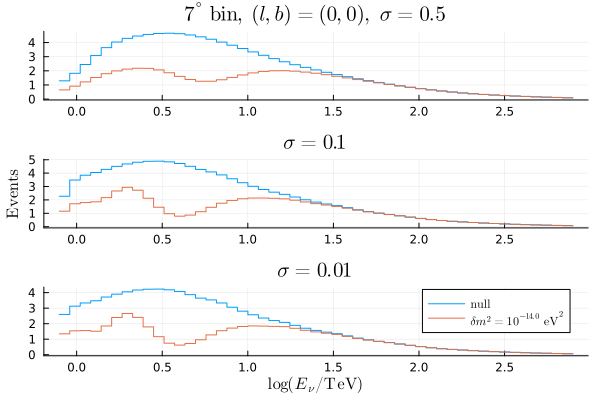

In [62]:
# varying σ

sample = range(log10(emin), log10(emax), length=50)

p05 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"7^{\circ}~\mathrm{bin},~(l, b) = (0, 0),~\sigma = 0.5"
)

p01 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.1, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.1, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"\sigma = 0.1"
)

p001 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.01, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.01, 0.122, 21.8, 2.7)],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    title=L"\sigma = 0.01"
)

plot(p05, p01, p001, layout=(3,1))

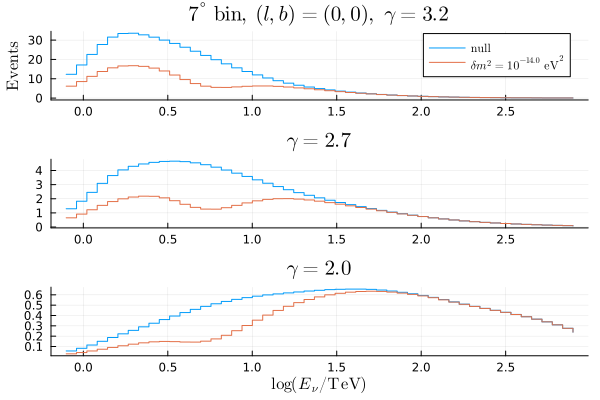

In [75]:
# varying γ

p30 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 3.2) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 3.2)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    # label=false,
    title=L"7^{\circ}~\mathrm{bin},~(l, b) = (0, 0),~\gamma = 3.2"
)

p27 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"\gamma = 2.7"
)

p20 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.0) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 2.0)],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"\gamma = 2.0"
)

plot(p30, p27, p20, layout=(3,1))

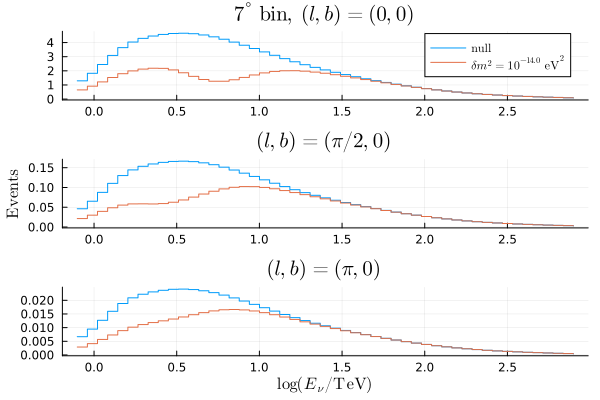

In [70]:
# varying l

p_0 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    # label=false,
    title=L"7^{\circ}~\mathrm{bin},~(l, b) = (0, 0)"
)

p_π2 = plot(sample, 
    [edistbinnedfreeparams(0, π/2, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), π/2, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"(l, b) = (\pi/2, 0)"
)

p_π = plot(sample, 
    [edistbinnedfreeparams(0, π, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), π, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"(l, b) = (\pi, 0)"
)

plot(p_0, p_π2, p_π, layout=(3,1))

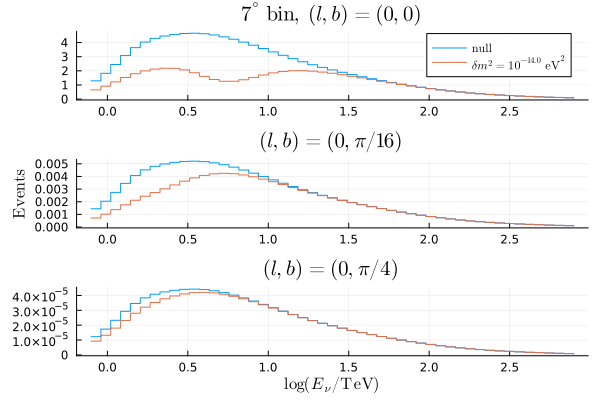

In [72]:
# varying b

pb_0 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    # label=false,
    title=L"7^{\circ}~\mathrm{bin},~(l, b) = (0, 0)"
)

pb_π16 = plot(sample, 
    [edistbinnedfreeparams(0, 0, π/16, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, π/16, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"(l, b) = (0, \pi/16)"
)

pb_π4 = plot(sample, 
    [edistbinnedfreeparams(0, 0, π/4, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, π/4, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"(l, b) = (0, \pi/4)"
)

plot(pb_0, pb_π16, pb_π4, layout=(3,1))

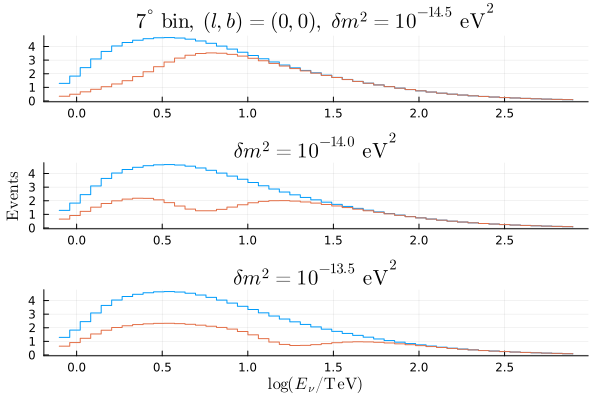

In [77]:
# varying δm²

p145 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.5), 0, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"7^{\circ}~\mathrm{bin},~(l, b) = (0, 0),~\delta m^2 = 10^{-14.5}~\mathrm{eV}^2"
)

p140 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"
)

p135 = plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7) edistbinnedfreeparams(10^(-13.5), 0, 0, 0.5, 0.122, 21.8, 2.7)],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    label=false,
    title=L"\delta m^2 = 10^{-13.5}~\mathrm{eV}^2"
)

plot(p145, p140, p135, layout=(3,1))

<h2>Plotting likelihoods</h2>

Let's now get a feel for how varying parameters alters the likelihood of our simulated data given the parameter-dependent hypothesis.

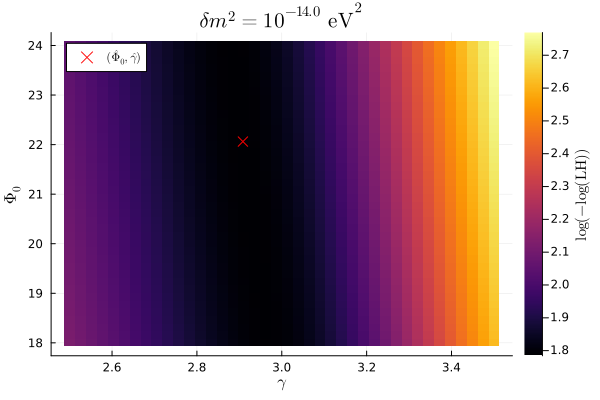

In [81]:
# Plotting likelihoods for different parameter values: δm² = -14 log eV

ϕrange = range(18, 24, length=40)
γrange = range(2.5, 3.5, length=40)

grid = Iterators.product(ϕrange, γrange)
lhvals = [negloglh(10^(-14), 0, 0, 0.122, ϕ₀, γ) for (ϕ₀, γ) in grid]
# lhmat = reshape(lhvals, length(ϕrange), length(γrange))

test = maxlh(10^(-14), 0, 0, 0.122)
params = Optim.minimizer(test)

loglhvals = log10.(lhvals)

hmap = heatmap(
    γrange, 
    ϕrange, 
    loglhvals, 
    γlims=(2, 4), 
    ϕlims=(18, 22), 
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2",
    ylabel=L"\Phi_0",
    xlabel=L"\gamma",
    colorbar_title=L"\log(-\log(\mathrm{LH}))"
)
scatter!(hmap, [params[2]], [params[1]], marker=:x, markersize=5, color=:red, label=L"(\hat{\Phi}_0, \hat{\gamma})")

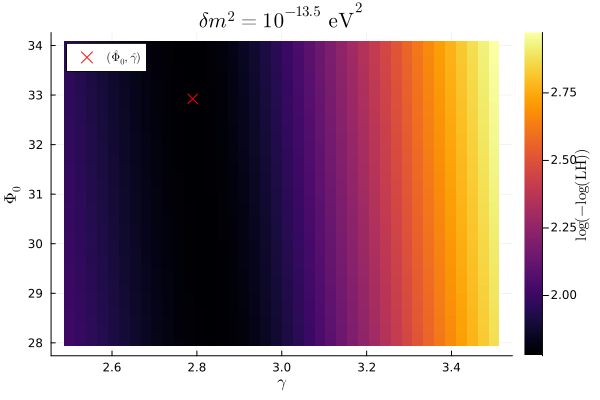

In [83]:
# δm² = -13.5 log eV

ϕrange = range(28, 34, length=40)
γrange = range(2.5, 3.5, length=40)

grid = Iterators.product(ϕrange, γrange)
lhvals = [negloglh(10^(-13.5), 0, 0, 0.122, ϕ₀, γ) for (ϕ₀, γ) in grid]
# lhmat = reshape(lhvals, length(ϕrange), length(γrange))

test = maxlh(10^(-13.5), 0, 0, 0.122)
params = Optim.minimizer(test)

loglhvals = log10.(lhvals)

hmap = heatmap(
    γrange, 
    ϕrange, 
    loglhvals, 
    γlims=(2, 4), 
    ϕlims=(18, 22), 
    title=L"\delta m^2 = 10^{-13.5}~\mathrm{eV}^2",
    ylabel=L"\Phi_0",
    xlabel=L"\gamma",
    colorbar_title=L"\log(-\log(\mathrm{LH}))"
)
scatter!(hmap, [params[2]], [params[1]], marker=:x, markersize=5, color=:red, label=L"(\hat{\Phi}_0, \hat{\gamma})")

<h2>Angular smearing</h2>

IceCube also has pretty bad angular resolution for cascade events of around $7^{\circ}$. To implement this, we use the healpy Python package and call the smoothing function.

<h2> All-sky Maximum Likelihood</h2>

When computing the maximum likelihood over the whole sky, we need to consider every angular bin. It should be noted, however, that the bins with the most events (near the GC) will contribute the most to this maximization. We thus need to find something like this:

For each $\{\Phi_0, \gamma\}$ pair, we calculate expected null data $k$ for each $\vec{\Theta}_{\mathrm{LOS}}$ bin. We then find expected results for a given PD hypothesis $\lambda$, compute the following,
$$
\mathrm{MaxLH}(\delta m^2) = \max_{\Phi_0, \gamma, \vec{\Theta}} \mathrm{Poisson}(\{k(\Phi_0, \gamma, \vec{\Theta})\} | \lambda(\delta m^2, \Phi_0, \gamma, \vec{\Theta})),
$$
and determine the pair $\{ \hat{\Phi_0}, \hat{\gamma} \}$ that results in this maximum.

In [157]:
# All sky binning and sensitivity functions

# Returns all sky binned event distributions
function anglesmearbin(dm2, ϕ₀, γ, res)

    bsize = π/60

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = []

    for l in l_range
        for b in b_range
            push!(skybins, edistbinnedfreeparams(dm2, l, (-b), 0.5, bsize, ϕ₀, γ))
        end
    end

    # Convert the list of function values to a 2D array
    edistvals = reshape(skybins, length(b_range), length(l_range))
    edistvals1 = edistvals'

    # Now the data are split into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:50]
    for i in 1:50
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 150
    npix = hp.nside2npix(nside)
    thedges = (bsize):bsize:(π-bsize)
    phedges = (0+bsize/2):bsize:(2π-bsize/2)
    theta, phi = np.meshgrid(thedges, phedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    function dist(index)

        # bin = reshape(ebins[index], 45, 90)
        bin = ebins[index]
        e = []
        
        for (j, thval) in enumerate(thedges)
            for (i, phval) in enumerate(phedges)
                    push!(e, bin[i, j])
            end
        end
    
        E = np.zeros(hp.nside2npix(nside))
    
        # E[pixel_indices] = e
        
        for (i, eval) in enumerate(e)
            E[pixel_indices[i]] = eval
        end
        
        E_smoothing = hp.smoothing(E, fwhm=np.radians(7.))
    
        twod_array = hp.cartview(E_smoothing, return_projected_map=true) 
    end

    # res in number of bins: each bin is 0.00785 radians, 400/res must be an integer
    nbins = convert(Int, 400/res)
    
    function anglebin(index, res)

        ebin = dist(index)
    
        bsize_l = res
        bsize_b = res
    
        nbins_l = convert(Int, (size(ebin, 1)/bsize_l))
        nbins_b = convert(Int, (size(ebin, 2)/bsize_b))
    
        binned_mat = reshape(ebin, bsize_l, nbins_l, bsize_b, nbins_b)
    
        bins = sum(binned_mat, dims=(1, 3))
    
        binned_sums = reshape(bins, nbins_l, nbins_b)
    end

    allsky_ebins = [anglebin(ebin, res) for ebin in 1:50]

    allskyedists = [zeros(50) for _ in 1:nbins, _ in 1:(2*nbins)]

    for i in 1:nbins
        for j in 1:(2*nbins)
            allskyedists[i, j] = [allsky_ebins[k][i, j] for k in 1:50]
        end
    end

    return allskyedists

end

# Approximate negloglh all sky function
function allskynllh(dm2, ϕ₀, γ)

    sumllh = 0

    for lval in (-pi/2):0.122:(pi/2)
        for bval in (-0.122):0.122:(0.122)
            sumllh += negloglh(dm2, lval, bval, 0.122, ϕ₀, γ)
        end
    end
    
    return sumllh
end

function allskymaxlh(dm2)

    function nllh(test)
        return allskynllh(dm2, test[1], test[2])
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

# all-sky LRT function as a function of delta m^2 and the angular resolution we want
function lhratio(dm2, res)

    # We first find the maximum-likelihood parameters:
    opt = allskymaxlh(dm2)
    optparams = Optim.minimizer(opt)

    nullarray = anglesmearbin(0, 21.8, 2.7, res)
    testarray = anglesmearbin(dm2, optparams[1], optparams[2], res)

    nbins = convert(Int, 400/res)
    
    array = zeros(nbins, 2*nbins)
    for i in 1:nbins
        for j in 1:(2*nbins)
            array[i, j] = lrt(nullarray[i, j], testarray[i, j])
        end
    end

    return array
end

lhratio (generic function with 2 methods)

<h2>Events with larger bins</h2>

We might expect that any pseudo-Dirac dips would be washed away by taking the whole sky events, but as shown below this is not necessarily the case––while the dip is definitely smaller, it is definitely still present.

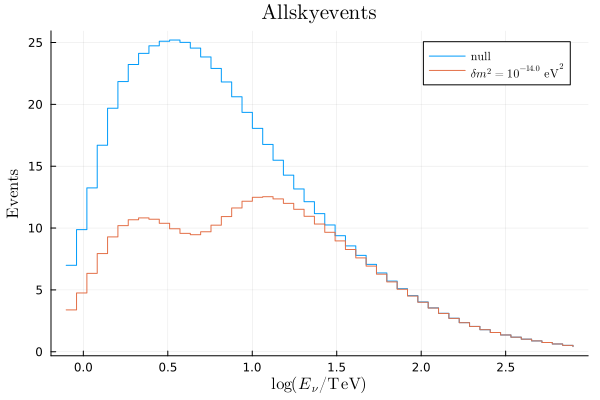

In [95]:
askyevents = anglesmearbin(0, 21.8, 2.7, 400)
askyeventsalt = anglesmearbin(10^(-14), 21.8, 2.7, 400)

allskyeventsnull = zeros(50)
allskyeventsalt = zeros(50)
for i in 1:50
    allskyeventsnull[i] = askyevents[1][i] + askyevents[2][i]
    allskyeventsalt[i] = askyeventsalt[1][i] + askyeventsalt[2][i]
end



In [99]:
mxlhallsky = allskymaxlh(10^(-14))
allskymaxparams = Optim.minimizer(mxlhallsky)

askyeventsalt_maxlh = anglesmearbin(10^(-14), allskymaxparams[1], allskymaxparams[2], 400)

allskyeventsalt_maxlh = zeros(50)

for i in 1:50
    allskyeventsalt_maxlh[i] = askyeventsalt_maxlh[1][i] + askyeventsalt_maxlh[2][i]
end

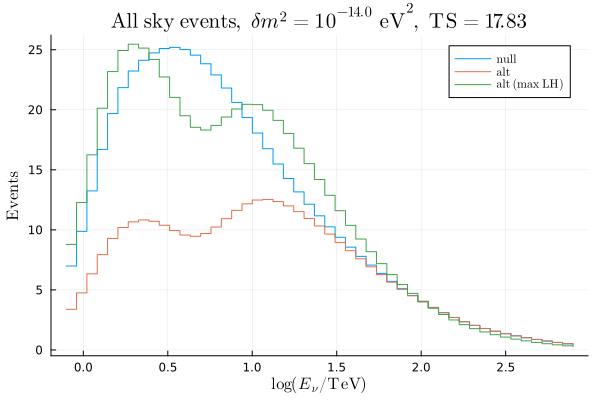

In [102]:
plot(sample, 
    [allskyeventsnull allskyeventsalt allskyeventsalt_maxlh],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{alt~(max~LH)}"],
    title=L"\mathrm{All~sky~events},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~\mathrm{TS} = 17.83"
)

<h1>Plotting all-sky sensitivities</h1>

In [114]:
testlh = lhratio(10^(-14.0), 16)

25×50 Matrix{Float64}:
 0.000482643  0.000489783  0.000489147  …  0.000489991  0.000482838
 0.000128672  0.000128574  0.000130739     0.00013406   0.000130448
 0.000192318  0.000191761  0.000193671     0.000200044  0.00019494
 0.00024432   0.000245381  0.000247984     0.000251122  0.000246029
 0.00034963   0.000356589  0.00036471      0.00033592   0.000342489
 0.000506153  0.000555305  0.000586903  …  0.000486366  0.00048312
 0.000736981  0.000832853  0.000925223     0.000697719  0.000692625
 0.00109271   0.00118338   0.00130215      0.000974859  0.0010298
 0.00190161   0.00181237   0.00190907      0.00178994   0.00190245
 0.00374547   0.0036123    0.00350053      0.00363696   0.00370874
 0.011208     0.0105062    0.00957872   …  0.0105784    0.0111319
 0.0232297    0.022648     0.0204271       0.0218231    0.0223654
 0.024037     0.0252081    0.0232538       0.0228998    0.0230969
 0.0128312    0.0125107    0.0106176       0.0112547    0.0125302
 0.004436     0.0037952    0.00353326  

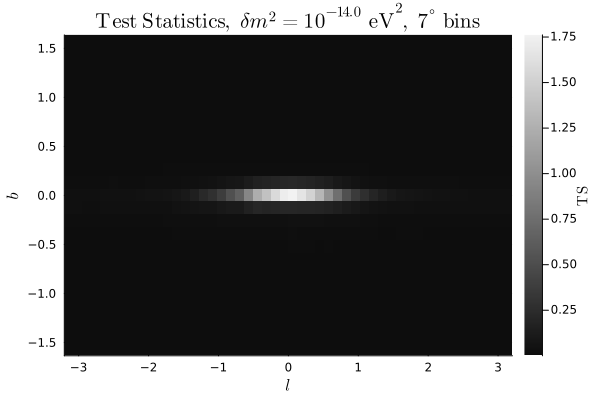

In [116]:
lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

heatmap(
    lvals,
    bvals,
    testlh,
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\mathrm{Test~Statistics},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~7^{\circ}~\mathrm{bins}",
    c=:grays,
    colorbar_title=L"\mathrm{TS}",
)

In [118]:
# All sky sensitivity function

function allskyts(dm2)

    mxlhallsky = allskymaxlh(dm2)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents = anglesmearbin(0, 21.8, 2.7, 400)
    askyeventsalt_maxlh = anglesmearbin(dm2, allskymaxparams[1], allskymaxparams[2], 400)

    allskyeventsnull = zeros(50)
    allskyeventsalt_maxlh = zeros(50)
    for i in 1:50
        allskyeventsnull[i] = askyevents[1][i] + askyevents[2][i]
        allskyeventsalt_maxlh[i] = askyeventsalt_maxlh[1][i] + askyeventsalt_maxlh[2][i]
    end

    ts = lrt(allskyeventsnull, allskyeventsalt_maxlh)
end

allskyts (generic function with 1 method)

In [119]:
# Sampling all sky sensitivities for different dm2 vals

logdmsample = range(-15, -12, length=31)
dmsample = 10 .^ logdmsample
teststats = [allskyts(dm2) for dm2 in dmsample]

31-element Vector{Float64}:
  0.7967867700703855
  1.9097583150525836
  4.4159637503044
  9.517989503610798
 17.797966241904568
 25.388381181521943
 24.738379504915372
 19.915921120932516
 17.709852272656768
 17.161132638444577
 17.829434913069385
 18.760122478507554
 19.506294644208225
  ⋮
 11.819639523944137
  9.934510763309742
  7.9909028182606825
  6.4783049397964225
  4.734852821783676
  3.511387050459596
  2.4040022664767644
  1.5851496699416516
  0.9041423566653457
  0.6063631161929723
  0.39144625200449235
  0.27425629529086337

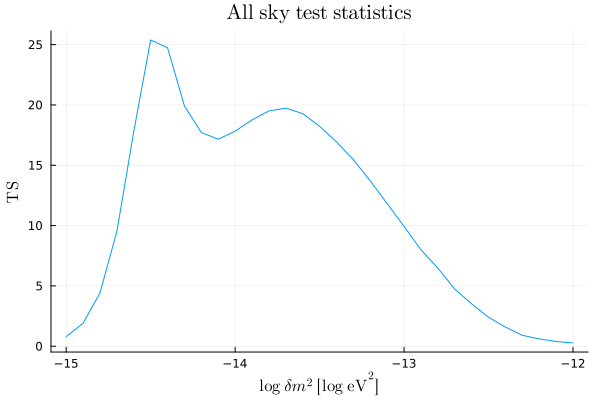

In [125]:
# Plotting all sky test statistics

plot(
    logdmsample, 
    teststats,
    xlabel=L"\log~\delta m^2~[\log~\mathrm{eV}^2]",
    ylabel=L"\mathrm{TS}",
    title=L"\mathrm{All~sky~test~statistics}",
    label=false
)

<h1>Experimenting with different resolutions and other parameters</h1>

What would happen if we had better or worse energy/angular resolution? Let's redefine some of our functions to keep these values free:

In [159]:
# Varying energy and angular resolution

# Returns all sky binned event distributions
function anglesmearbin2(dm2, ϕ₀, γ, res, σ, θres)

    bsize = π/60

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = []

    for l in l_range
        for b in b_range
            push!(skybins, edistbinnedfreeparams(dm2, l, (-b), σ, bsize, ϕ₀, γ))
        end
    end

    # Convert the list of function values to a 2D array
    edistvals = reshape(skybins, length(b_range), length(l_range))
    edistvals1 = edistvals'

    # Now the data are split into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:50]
    for i in 1:50
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 150
    npix = hp.nside2npix(nside)
    thedges = (bsize):bsize:(π-bsize)
    phedges = (0+bsize/2):bsize:(2π-bsize/2)
    theta, phi = np.meshgrid(thedges, phedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    function dist(index)

        # bin = reshape(ebins[index], 45, 90)
        bin = ebins[index]
        e = []
        
        for (j, thval) in enumerate(thedges)
            for (i, phval) in enumerate(phedges)
                    push!(e, bin[i, j])
            end
        end
    
        E = np.zeros(hp.nside2npix(nside))
    
        # E[pixel_indices] = e
        
        for (i, eval) in enumerate(e)
            E[pixel_indices[i]] = eval
        end
        
        E_smoothing = hp.smoothing(E, fwhm=np.radians(θres))
    
        twod_array = hp.cartview(E_smoothing, return_projected_map=true) 
    end

    # res in number of bins: each bin is 0.00785 radians, 400/res must be an integer
    nbins = convert(Int, 400/res)
    
    function anglebin(index, res)

        ebin = dist(index)
    
        bsize_l = res
        bsize_b = res
    
        nbins_l = convert(Int, (size(ebin, 1)/bsize_l))
        nbins_b = convert(Int, (size(ebin, 2)/bsize_b))
    
        binned_mat = reshape(ebin, bsize_l, nbins_l, bsize_b, nbins_b)
    
        bins = sum(binned_mat, dims=(1, 3))
    
        binned_sums = reshape(bins, nbins_l, nbins_b)
    end

    allsky_ebins = [anglebin(ebin, res) for ebin in 1:50]

    allskyedists = [zeros(50) for _ in 1:nbins, _ in 1:(2*nbins)]

    for i in 1:nbins
        for j in 1:(2*nbins)
            allskyedists[i, j] = [allsky_ebins[k][i, j] for k in 1:50]
        end
    end

    return allskyedists

end

function negloglh2(dm2, l, b, σ, θ, ϕ₀, γ)

    # σ = 0.5
    nullhyp = edistbinnedfreeparams(0, l, b, σ, θ, 21.8, 2.7)
    althyp = edistbinnedfreeparams(dm2, l, b, σ, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

# Approximate negloglh all sky function
function allskynllh2(dm2, ϕ₀, γ, σ)

    sumllh = 0

    for lval in (-pi/2):0.122:(pi/2)
        for bval in (-0.122):0.122:(0.122)
            sumllh += negloglh2(dm2, lval, bval, σ, 0.122, ϕ₀, γ)
        end
    end
    
    return sumllh
end

function allskymaxlh2(dm2, σ)

    function nllh(test)
        return allskynllh2(dm2, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

# all-sky LRT function as a function of delta m^2 and the angular resolution we want
function lhratio2(dm2, res, σ, θres)

    # We first find the maximum-likelihood parameters:
    opt = allskymaxlh2(dm2, σ)
    optparams = Optim.minimizer(opt)

    nullarray = anglesmearbin2(0, 21.8, 2.7, res, σ, θres)
    testarray = anglesmearbin2(dm2, optparams[1], optparams[2], res, σ, θres)

    nbins = convert(Int, 400/res)
    
    array = zeros(nbins, 2*nbins)
    for i in 1:nbins
        for j in 1:(2*nbins)
            array[i, j] = lrt(nullarray[i, j], testarray[i, j])
        end
    end

    return array
end

function allskyts2(dm2, σ, θres)

    mxlhallsky = allskymaxlh2(dm2, σ)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents = anglesmearbin2(0, 21.8, 2.7, 400, σ, θres)
    askyeventsalt_maxlh = anglesmearbin2(dm2, allskymaxparams[1], allskymaxparams[2], 400, σ, θres)

    allskyeventsnull = zeros(50)
    allskyeventsalt_maxlh = zeros(50)
    for i in 1:50
        allskyeventsnull[i] = askyevents[1][i] + askyevents[2][i]
        allskyeventsalt_maxlh[i] = askyeventsalt_maxlh[1][i] + askyeventsalt_maxlh[2][i]
    end

    ts = lrt(allskyeventsnull, allskyeventsalt_maxlh)
end

allskyts2 (generic function with 1 method)

In [166]:
testvary = lhratio2(10^(-14), 16, 0.1, 3)

25×50 Matrix{Float64}:
 0.00296589   0.0031485    0.00313786   …  0.003162     0.00297795
 0.000160174  0.000160355  0.000166887     0.000166309  0.000162096
 0.000196155  0.000188855  0.000197835     0.000197275  0.000198916
 0.000240178  0.000243709  0.000247898     0.000250974  0.000242405
 0.000362537  0.000347756  0.000373225     0.00032904   0.000355538
 0.000500607  0.000564689  0.000592927  …  0.000493347  0.000476682
 0.000739509  0.000841034  0.000957962     0.000710442  0.000693356
 0.00106297   0.00116931   0.00130753      0.000941598  0.000989332
 0.00190951   0.00177521   0.00191711      0.00179262   0.00192212
 0.00352341   0.00343211   0.00326052      0.00344701   0.00345669
 0.0104488    0.00986399   0.00892212   …  0.00990721   0.0104607
 0.0266108    0.0259383    0.0223196       0.0247274    0.0254812
 0.0271126    0.0301649    0.0264724       0.027381     0.0270526
 0.0136404    0.0131813    0.0103751       0.0120485    0.0134565
 0.0039919    0.00325907   0.0031721

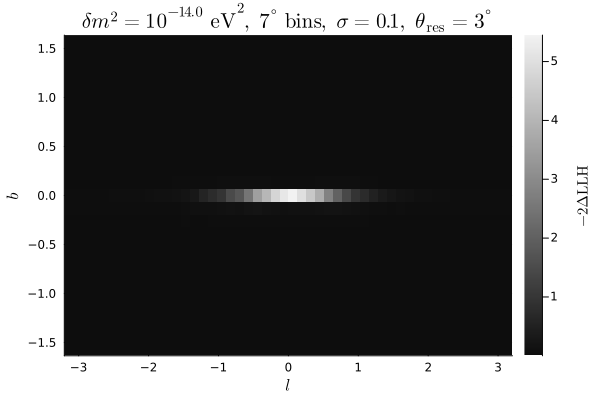

In [170]:
lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

heatmap(
    lvals,
    bvals,
    testvary,
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~7^{\circ}~\mathrm{bins},~\sigma = 0.1,~\theta_{\mathrm{res}} = 3^{\circ}",
    c=:grays,
    colorbar_title=L"-2 \Delta \mathrm{LLH}",
)